In [1]:
import tensorflow as tf

model_folder = 'models/metrabs_eff2s_y4/'

model = tf.saved_model.load(model_folder)

2021-12-29 11:31:11.093943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 11:31:11.100797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 11:31:11.101265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 11:31:11.102185: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
model.crop_model.variables[-4].shape

TensorShape([1, 1, 1280, 288])

In [3]:
vars = model.crop_model.variables
model.crop_model.backbone

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fc5f1b673d0>

In [4]:
name_shape = [['/'.join(v.name.split('/')[1:]), v.shape] for v in vars if 'tpu' not in v.name]

In [5]:
import sys
sys.path.append('/home/tobi/apps/metrabs/metrabs/src')
from backbones.efficientnet.effnetv2_model import *
import backbones.efficientnet.effnetv2_utils as effnet_util

import tfu
effnet_util.set_batchnorm(effnet_util.BatchNormalization)
tfu.set_data_format('NHWC')
tfu.set_dtype(tf.float32)

mod = get_model('efficientnetv2-s', include_top=False, pretrained=False, with_endpoints=False)

In [6]:
# import data.datasets3d
# from data.joint_info import JointInfo
# import models
# from options import FLAGS
# FLAGS.transform_coords = False
# FLAGS.depth = 1
# FLAGS.stride_test = 32
# FLAGS.stride_train = 32

# FLAGS.final_transposed_conv = 8
# FLAGS.proc_side = 128
# FLAGS.centered_stride = True
# FLAGS.box_size_mm = 2200
# FLAGS.weak_perspective = True

# #joint_names = (
# #    'htop,neck,rsho,relb,rwri,lsho,lelb,lwri,rhip,rkne,rank,lhip,lkne,lank,spin,head,pelv,dummy')
# #edges = (
# #    'htop-head-neck-spin-pelv-lhip-lkne-lank,'
# #    'lwri-lelb-lsho-neck-rsho-relb-rwri,pelv-rhip-rkne-rank')
# #joint_info = JointInfo(joint_names, edges)

# joint_names = [str(l) for l in list(model.joint_names.numpy())]
# joint_edges = [tuple(j) for j in list(model.joint_edges.numpy())]
# joint_info = JointInfo(joint_names, joint_edges)

# mod_met = models.metrabs.Metrabs(mod, joint_info)

In [7]:
model.crop_model.variables[-4].shape

TensorShape([1, 1, 1280, 288])

In [8]:
new_vars = mod.variables
name_shape_new = [['/'.join(v.name.split('/')[1:]), v.shape] for v in new_vars if 'tpu' not in v.name]

In [9]:
mod.set_weights(vars[:-4])

In [10]:
# save model w/ metrabs heads!

UNKNOWN_INTRINSIC = np.ones((3,3))*-1

@tf.function()
def my_predict(my_prediction_inputs, **kwargs):
    prediction = mod(my_prediction_inputs, training=False)
    return {"prediction": prediction}

my_signatures = my_predict.get_concrete_function(
   my_prediction_inputs=tf.TensorSpec([1, 256, 256, 3], dtype=tf.dtypes.float16, name="image")
)

tf.saved_model.save(mod, "mods/effnet-s_raw", signatures=my_signatures)

2021-12-29 11:32:17.205460: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: mods/effnet-s_raw/assets


INFO:tensorflow:Assets written to: mods/effnet-s_raw/assets


2021-12-29 11:32:56.467767: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


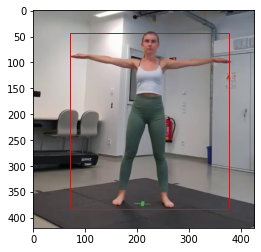

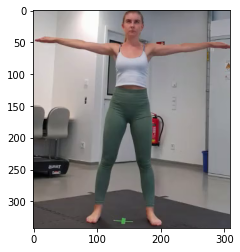

det took 6548.76ms
pred took 211.78ms
metrabs took 171.94ms
total took 6978.56ms


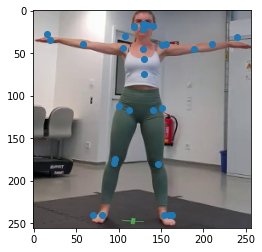

In [11]:
# test the full pipeline in its parts to speed up and reassemble later

%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image
import cv2

import time
import matplotlib.patches as patches
from PIL import Image

t3 = time.time()
img = Image.open('cpp/image.png')

t = time.time()
bbox = model.detector.predict_single_image(img)
t = time.time() - t

x, y, wd, ht, conf = bbox[0]
crop = np.array(img)[int(y):int(y+ht), int(x):int(x+wd)]
res = cv2.resize(crop, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

Image.fromarray(res).save('cpp/crop.png')

inp = res.astype(np.float16)
inp /= 256.

t2 = time.time()
pred = mod(inp[np.newaxis,...], False)
t2 = time.time() - t2

t4 = time.time()
pred2d, pred3d = model.crop_model.heatmap_heads(tf.cast(pred, tf.float16), training=False)
#coords3d_abs = tfu3d.reconstruct_absolute(coords2d, coords3d, intrinsics)
t4 = time.time() - t4

t3 = time.time() - t3

rect = patches.Rectangle((x, y), wd, ht, linewidth=1, edgecolor='r', facecolor='none')
fig, ax = plt.subplots()
ax.imshow(img)
ax.add_patch(rect)
plt.show()

plt.imshow(crop)
plt.show()
plt.imshow(res)

xs = pred2d.numpy()[0, :, 0]
ys = pred2d.numpy()[0, :, 1]
plt.scatter(xs, ys)

print('det took %.2fms'%(t*1000))
print('pred took %.2fms'%(t2*1000))
print('metrabs took %.2fms'%(t4*1000))
print('total took %.2fms'%(t3*1000))
#print(pred)

In [12]:
# same thing sped up!?!
# nvidia-tut: https://developer.nvidia.com/blog/speeding-up-deep-learning-inference-using-tensorflow-onnx-and-tensorrt/

In [13]:
# save metrabs head only!

@tf.function()
def metr_head(my_prediction_inputs, **kwargs):
    #prediction = mod(my_prediction_inputs, training=False)
    pred2d, pred3d = model.crop_model.heatmap_heads(tf.cast(my_prediction_inputs, tf.float16), training=False)
    return {"prediction": pred2d}

metrab_sig = metr_head.get_concrete_function(
   my_prediction_inputs=tf.TensorSpec([1, 8, 8, 1280], dtype=tf.dtypes.float32, name="feature")
)

if False:
    tf.saved_model.save(model.crop_model.heatmap_heads, "mods/metrab_head", signatures=metrab_sig)
    # confirm consistency briefly
    metrab_mod = tf.saved_model.load('mods/metrab_head/')
    pred2d_metrab, _ = metrab_mod(tf.cast(pred, tf.float16))
    assert(np.all(pred2d_metrab == pred2d)), 'saved model yields diff result'

INFO:tensorflow:Assets written to: mods/metrab_head/assets


INFO:tensorflow:Assets written to: mods/metrab_head/assets


In [14]:
pred

<tf.Tensor: shape=(1, 8, 8, 1280), dtype=float32, numpy=
array([[[[-1.82155485e-03, -2.74089366e-01, -1.11057021e-01, ...,
          -1.17378414e-01, -2.77747840e-01, -2.44969621e-01],
         [ 9.06992500e-06, -2.53789127e-01, -1.84764981e-01, ...,
          -2.76416332e-01, -2.72673696e-01, -2.42264345e-01],
         [-2.78196543e-01, -2.77962089e-01, -2.63569325e-01, ...,
          -2.65649170e-01, -2.78411299e-01, -1.96987793e-01],
         ...,
         [-2.76616901e-01, -2.77649611e-01, -2.75071979e-01, ...,
          -2.65289038e-01, -2.78334558e-01, -2.78448105e-01],
         [-1.09809995e-01, -1.74542487e-01, -1.65930137e-01, ...,
          -2.72815973e-01, -2.50683904e-01, -2.47595340e-01],
         [-1.71470776e-01, -5.76963164e-02, -8.43585730e-02, ...,
          -2.67943740e-01, -2.57323265e-01, -2.00479999e-01]],

        [[ 1.47578612e-01, -2.29944527e-01, -3.09880059e-02, ...,
          -1.65526837e-01, -1.02838399e-02, -1.64513409e-01],
         [ 1.48373991e-01, -1.8

In [16]:
inp

array([[[0.699 , 0.699 , 0.699 ],
        [0.699 , 0.699 , 0.699 ],
        [0.699 , 0.699 , 0.699 ],
        ...,
        [0.5156, 0.535 , 0.574 ],
        [0.5156, 0.535 , 0.574 ],
        [0.5156, 0.535 , 0.574 ]],

       [[0.707 , 0.703 , 0.707 ],
        [0.707 , 0.703 , 0.703 ],
        [0.707 , 0.703 , 0.703 ],
        ...,
        [0.5195, 0.539 , 0.574 ],
        [0.5195, 0.539 , 0.574 ],
        [0.5195, 0.539 , 0.574 ]],

       [[0.711 , 0.703 , 0.707 ],
        [0.707 , 0.699 , 0.703 ],
        [0.707 , 0.699 , 0.703 ],
        ...,
        [0.5156, 0.535 , 0.5664],
        [0.5156, 0.535 , 0.5664],
        [0.5156, 0.535 , 0.5664]],

       ...,

       [[0.289 , 0.2695, 0.2656],
        [0.293 , 0.2734, 0.2695],
        [0.293 , 0.2734, 0.2695],
        ...,
        [0.2617, 0.2617, 0.293 ],
        [0.2617, 0.2617, 0.293 ],
        [0.2617, 0.2617, 0.293 ]],

       [[0.293 , 0.2734, 0.2695],
        [0.293 , 0.2734, 0.2695],
        [0.293 , 0.2734, 0.2695],
        .